# Property-Friends Real Estate Valuation - Exploratory Data Analysis

## Introduction

This notebook presents a comprehensive exploratory analysis of the real estate data used for the Property-Friends valuation model. The analysis follows a structured, methodical approach to understand the data characteristics, identify patterns, and detect outliers that may impact the property valuation model's accuracy and reliability.

Real estate valuation requires careful consideration of multiple factors including property characteristics, location, and market conditions. This analysis aims to provide insights that will inform the development of a robust valuation model.

## Objectives:

1. **Data Quality Assessment**:
   - Examine and handle missing/zero values
   - Identify and address data inconsistencies
   - Ensure data integrity for modeling

2. **Statistical Analysis**:
   - Analyze property price distributions and key statistics
   - Identify central tendencies and variability in the data
   - Understand the range and distribution of key features

3. **Relationship Exploration**:
   - Explore correlations between property features and prices
   - Identify key value drivers in real estate pricing
   - Discover interaction effects between different features

4. **Geographic Analysis**:
   - Identify spatial patterns in property data
   - Analyze location-based price variations
   - Visualize geographic distribution of properties

5. **Advanced Outlier Detection**:
   - Implement hierarchical grouping for context-aware outlier detection
   - Separate anomalous properties from normal market behavior
   - Prepare clean datasets for model training


In [15]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# Load the training and test datasets
from src.utils.helpers import load_original_data
# Import the outlier detection function from our production code
from src.data.outlier_handler import separate_outliers_and_save
from src.data.generate_schema import generate_schema, schema_to_json, visualize_statistics, validate_against_schema
import logging
# Set plot style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('Set2')
%matplotlib inline


## 1. Data Loading and Initial Exploration

### Purpose
In this initial phase, we load the training and test datasets, examine their basic properties, and establish a foundational understanding of the data structure. This step is crucial as it informs all subsequent analysis and modeling decisions.

### Approach
We use two data loading functions:
- `load_original_data()`: Loads data directly from the source version directory
- `load_latest_data()`: Loads the most recent processed version (used in later sections)

After loading, we examine the data's dimensions, column types, and basic statistical properties to gain insights into the dataset's characteristics.


In [16]:

# Load original data directly from the data version directory (v1)
train_data = load_original_data(data_type='train')
test_data = load_original_data(data_type='test')

print(f"Original training data shape: {train_data.shape}")
print(f"Original test data shape: {test_data.shape}")


INFO:src.utils.helpers:Loading original train data from: /Users/joserubio/Desktop/proyectos/bain/data/v2/train.csv
INFO:src.utils.helpers:Loading original test data from: /Users/joserubio/Desktop/proyectos/bain/data/v2/test.csv


Original training data shape: (16212, 9)
Original test data shape: (6949, 9)


In [17]:
# Display basic information about the training data
train_data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16212 entries, 0 to 16211
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   type             16212 non-null  object 
 1   sector           16212 non-null  object 
 2   net_usable_area  16212 non-null  float64
 3   net_area         16212 non-null  float64
 4   n_rooms          16212 non-null  float64
 5   n_bathroom       16212 non-null  float64
 6   latitude         16212 non-null  float64
 7   longitude        16212 non-null  float64
 8   price            16212 non-null  int64  
dtypes: float64(6), int64(1), object(2)
memory usage: 1.1+ MB


In [18]:
# Display summary statistics
train_data.describe()


,net_usable_area,net_area,n_rooms,n_bathroom,latitude,longitude,price
count,16212.000000,1.621200e+04,16212.000000,16212.000000,16212.000000,16212.000000,16212.000000
mean,249.409339,6.186665e+02,3.590550,3.024241,-33.403506,-70.560875,16180.463607
std,2774.766864,1.169530e+04,1.449744,1.331352,0.036072,0.036081,12774.658484
min,0.000000,0.000000e+00,0.000000,0.000000,-33.524410,-70.643660,0.000000
25%,98.000000,1.100000e+02,3.000000,2.000000,-33.431350,-70.589872,8079.750000
50%,140.000000,1.984750e+02,3.000000,3.000000,-33.406670,-70.564120,12500.000000
75%,242.000000,4.750000e+02,4.000000,4.000000,-33.378327,-70.531537,20000.000000
max,180116.000000,1.430000e+06,55.000000,55.000000,-33.305250,-70.431890,215000.000000


## 2. Data Quality Assessment and Cleaning

### Purpose
High-quality data is the foundation of reliable real estate valuation models. In this section, we systematically identify and address data quality issues, with a particular focus on zero values in critical fields that could significantly distort our analysis and model predictions.

### Methodology
We employ a multi-step approach to data quality assessment:
1. **Identification**: Detect zero values across all numeric columns
2. **Quantification**: Measure the extent of quality issues in each field
3. **Remediation**: Remove problematic records to create a clean dataset

This process ensures that subsequent analyses are based on reliable, high-integrity data, which is essential for developing accurate valuation models.


In [19]:
# Check for zero values in important numeric columns
numeric_cols = ['net_usable_area', 'net_area', 'n_rooms',
                'n_bathroom', 'latitude', 'longitude', 'price']

for col in numeric_cols:
    zero_count = (train_data[col] == 0).sum()
    if zero_count > 0:
        print(f"Column '{col}' has {zero_count} zero values.")


Column 'net_usable_area' has 32 zero values.
Column 'net_area' has 32 zero values.
Column 'n_rooms' has 31 zero values.
Column 'n_bathroom' has 131 zero values.
Column 'price' has 1 zero values.


In [20]:
# Remove rows with zero values as they likely represent data errors
df_no_zeros = train_data[~(train_data == 0).any(axis=1)].copy()
print(f"Original data shape: {train_data.shape}")
print(f"Data without zeros shape: {df_no_zeros.shape}")
print(f"Removed {len(train_data) - len(df_no_zeros)} rows with zero values")


Original data shape: (16212, 9)
Data without zeros shape: (16051, 9)
Removed 161 rows with zero values


In [21]:
# Check summary statistics after removing zeros
df_no_zeros.describe()

,net_usable_area,net_area,n_rooms,n_bathroom,latitude,longitude,price
count,16051.000000,1.605100e+04,16051.000000,16051.000000,16051.000000,16051.000000,16051.000000
mean,249.651686,6.193900e+02,3.595352,3.049280,-33.403539,-70.560968,16128.839200
std,2788.476694,1.175345e+04,1.425891,1.308361,0.036057,0.036038,12692.241237
min,10.000000,1.000000e+00,1.000000,1.000000,-33.524410,-70.643660,11.000000
25%,98.000000,1.100000e+02,3.000000,2.000000,-33.431400,-70.589890,8044.500000
50%,140.000000,1.980000e+02,3.000000,3.000000,-33.406640,-70.564300,12500.000000
75%,240.000000,4.720000e+02,4.000000,4.000000,-33.378390,-70.531705,20000.000000
max,180116.000000,1.430000e+06,55.000000,55.000000,-33.305250,-70.431890,215000.000000


## 3. Missing Value Analysis and Treatment

### Purpose
Missing values can significantly impact model performance and lead to biased predictions. This section provides a comprehensive assessment of missing data patterns in our dataset, which is essential for developing appropriate treatment strategies.

### Importance in Real Estate Valuation
In real estate data, missing values may indicate:
- Data collection issues
- Properties with unique characteristics
- Systematic patterns related to property types or regions

### Analytical Approach
We quantify missing values across all features and calculate their prevalence as percentages of the total dataset. This analysis informs decisions about:
- Whether to impute missing values or exclude affected observations
- Which imputation methods would be most appropriate
- If missing data patterns themselves contain valuable information


In [22]:
# Check for missing values
missing_values = df_no_zeros.isnull().sum()
missing_percentage = (missing_values / len(df_no_zeros)) * 100

missing_df = pd.DataFrame({
    'Missing Values': missing_values,
    'Percentage': missing_percentage
})

missing_df


,Missing Values,Percentage
type,0,0.0
sector,0,0.0
net_usable_area,0,0.0
net_area,0,0.0
n_rooms,0,0.0
n_bathroom,0,0.0
latitude,0,0.0
longitude,0,0.0
price,0,0.0


## 4. Advanced Outlier Detection with Hierarchical Grouping

### Purpose
Outlier detection is particularly challenging in real estate valuation due to the heterogeneous nature of properties. This section implements an advanced, context-aware outlier detection methodology that accounts for the natural segmentation of the real estate market.

### Limitations of Traditional Approaches
Standard statistical methods for outlier detection (e.g., z-scores, simple IQR) often fail in real estate analysis because:
- Properties naturally cluster into distinct market segments
- Price distributions vary dramatically across property types and locations
- What constitutes an "outlier" depends on the specific property context

### Hierarchical Grouping Methodology
Our approach implements a multi-level hierarchical grouping strategy:

1. **Primary Segmentation**: Group properties by:
   - Geographic sector (location)
   - Property type (apartment, house, etc.)
   - Number of rooms
   - Number of bathrooms

2. **Secondary Segmentation**: Within each primary group:
   - Create area bins to further segment properties by size
   - This accounts for the strong relationship between area and price

3. **Contextual Outlier Detection**: Within each fine-grained segment:
   - Apply Interquartile Range (IQR) method to detect price outliers
   - Calculate segment-specific thresholds based on price distribution
   - Flag properties outside the acceptable range (Q1-1.5*IQR, Q3+1.5*IQR)

This sophisticated approach ensures that outliers are identified relative to truly comparable properties, resulting in more meaningful and actionable insights for model development.


Total outliers detected: 699

Outlier Analysis Summary:
              Metric    Value
      Total Outliers      699
  Outlier Percentage    4.35%
Avg Price (Outliers)  $26,516
  Avg Price (Normal)  $15,656
Min Price (Outliers)      $11
Max Price (Outliers) $120,000
 Avg Area (Outliers)   235 m²
   Avg Area (Normal)   250 m²

Outliers by Property Type:
type
departamento    465
casa            234
Name: count, dtype: int64

Outliers by Sector (Top 10):
sector
las condes      290
vitacura        155
lo barnechea    101
nunoa            66
providencia      54
la reina         33
Name: count, dtype: int64


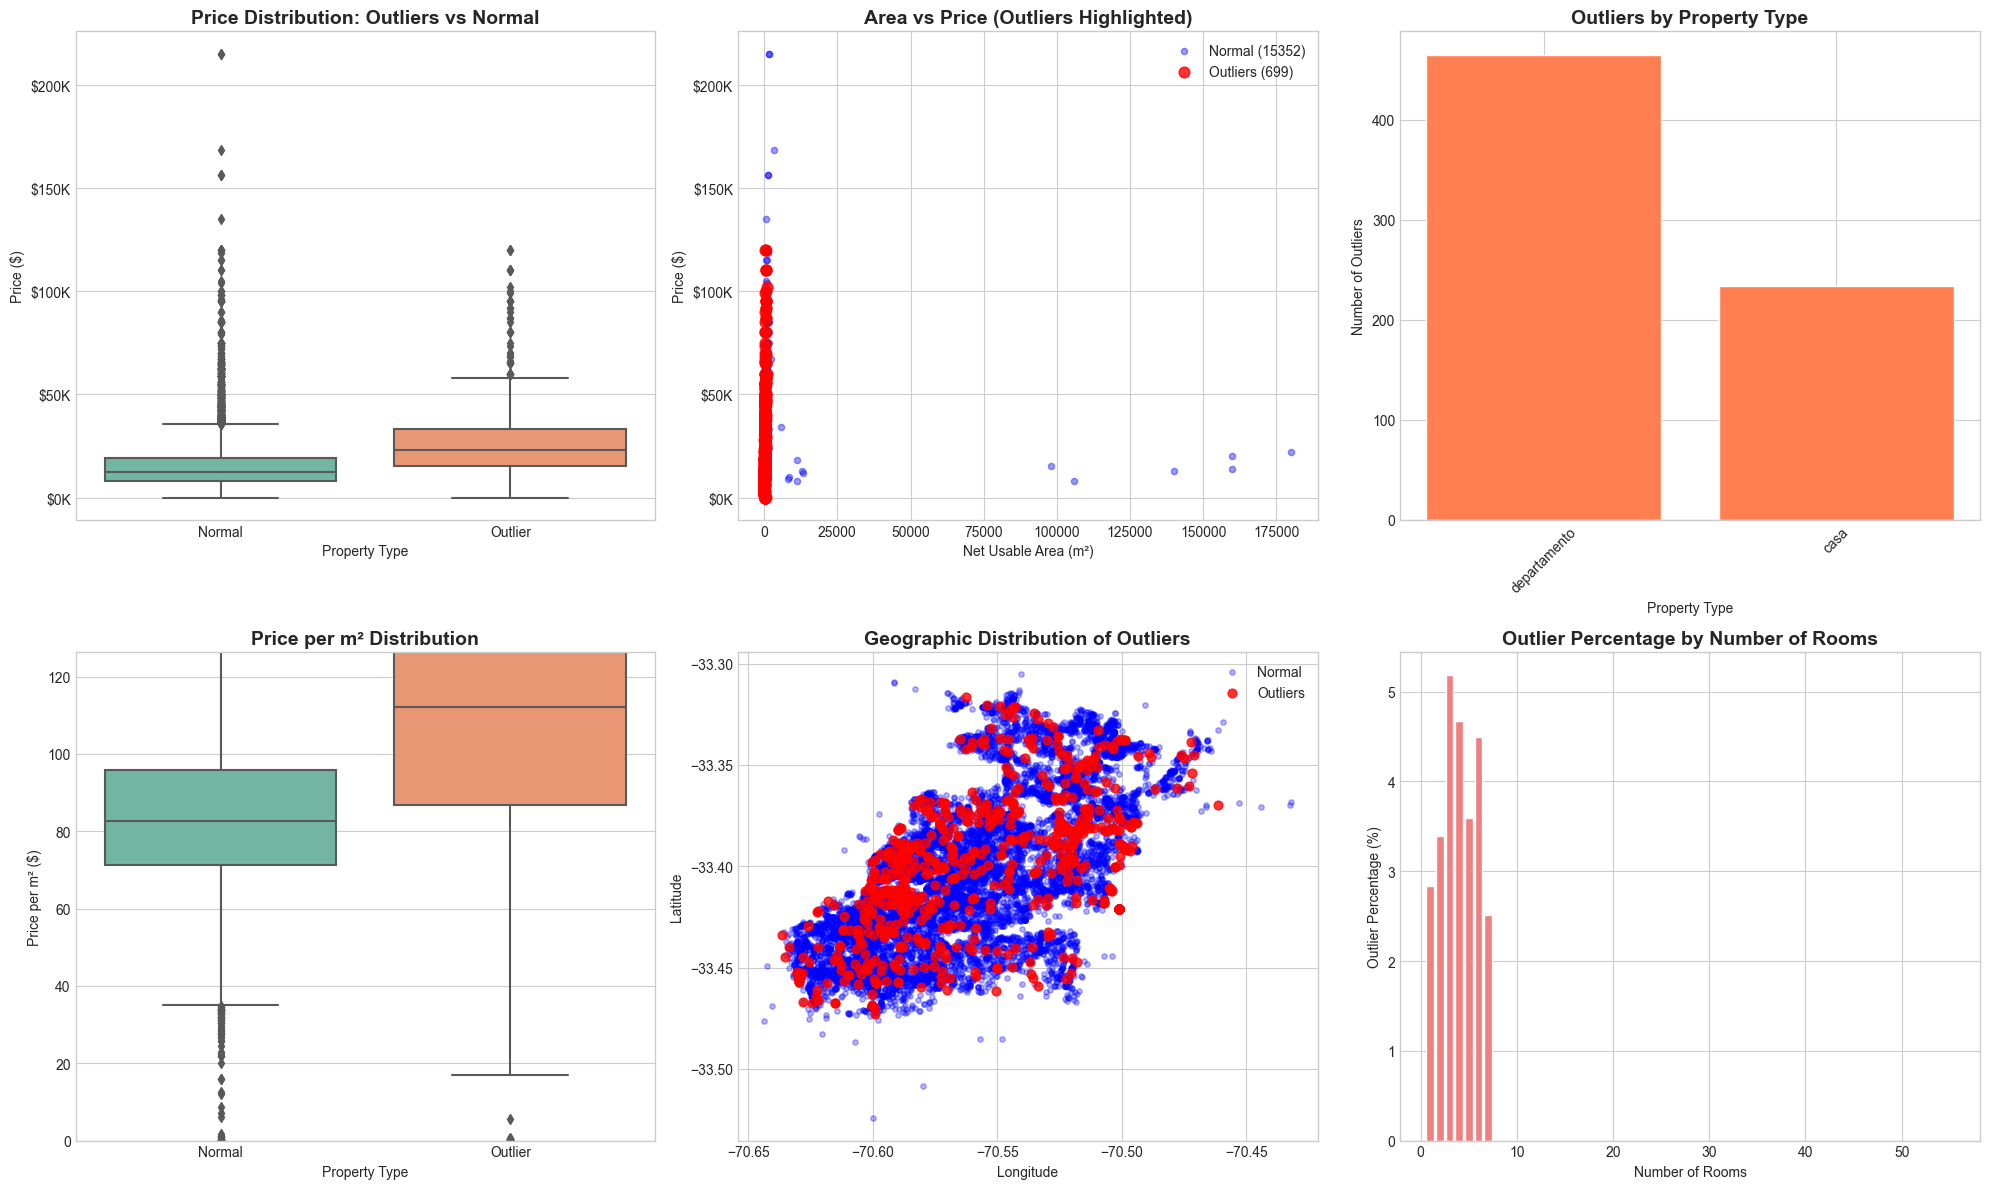


Top 10 Most Extreme Outliers:
type       sector  net_usable_area  n_rooms  n_bathroom price_formatted
casa   las condes            500.0      5.0         4.0        $120,000
casa     vitacura            370.0      4.0         5.0        $120,000
casa   las condes            680.0      6.0         6.0        $110,000
casa lo barnechea            600.0      5.0         4.0        $110,000
casa   las condes            594.0      4.0         5.0        $110,000
casa   las condes            800.0      5.0         5.0        $102,000
casa     vitacura            600.0      5.0         6.0        $100,000
casa     vitacura            370.0      5.0         4.0         $99,000
casa     vitacura            529.0      5.0         4.0         $95,000
casa   las condes            610.0      6.0         6.0         $95,000


In [23]:
def detect_outliers_hierarchical(df):
    """
    Detects outliers using hierarchical grouping approach with area binning.
    Groups by sector -> type -> n_rooms -> n_bathroom, then creates area bins
    within each group for more precise outlier detection.
    """
    df_clean = df[~(df == 0).any(axis=1)].copy()
    df_clean['is_outlier'] = False

    # Group by sector -> type -> n_rooms -> n_bathroom
    for (sector, prop_type, rooms, bathrooms), group in df_clean.groupby(['sector', 'type', 'n_rooms', 'n_bathroom']):
        if len(group) < 5:  # Skip small groups
            continue

        # Create area bins within each group
        group = group.copy()
        group['area_bin'] = pd.cut(group['net_usable_area'], bins=5, labels=False)

        # Detect outliers within each area bin
        for bin_id, bin_group in group.groupby('area_bin'):
            if len(bin_group) < 3:
                continue

            Q1 = bin_group['price'].quantile(0.25)
            Q3 = bin_group['price'].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR

            outlier_mask = (bin_group['price'] < lower_bound) | (bin_group['price'] > upper_bound)
            df_clean.loc[bin_group.index[outlier_mask], 'is_outlier'] = True

    return df_clean

# Apply hierarchical outlier detection
df_with_outliers = detect_outliers_hierarchical(df_no_zeros)
outliers = df_with_outliers[df_with_outliers['is_outlier']]

print(f"Total outliers detected: {len(outliers)}")

if len(outliers) > 0:
    # Enhanced outlier summary table
    outlier_summary = pd.DataFrame({
        'Metric': ['Total Outliers', 'Outlier Percentage', 'Avg Price (Outliers)', 'Avg Price (Normal)',
                   'Min Price (Outliers)', 'Max Price (Outliers)', 'Avg Area (Outliers)', 'Avg Area (Normal)'],
        'Value': [
            len(outliers),
            f"{len(outliers)/len(df_with_outliers)*100:.2f}%",
            f"${outliers['price'].mean():,.0f}",
            f"${df_with_outliers[~df_with_outliers['is_outlier']]['price'].mean():,.0f}",
            f"${outliers['price'].min():,.0f}",
            f"${outliers['price'].max():,.0f}",
            f"{outliers['net_usable_area'].mean():.0f} m²",
            f"{df_with_outliers[~df_with_outliers['is_outlier']]['net_usable_area'].mean():.0f} m²"
        ]
    })

    print("\nOutlier Analysis Summary:")
    print(outlier_summary.to_string(index=False))

    # Outliers by category
    print("\nOutliers by Property Type:")
    print(outliers['type'].value_counts())

    print("\nOutliers by Sector (Top 10):")
    print(outliers['sector'].value_counts().head(10))

    # Enhanced visualizations
    fig, axes = plt.subplots(2, 3, figsize=(20, 12))

    # 1. Price distribution comparison
    sns.boxplot(x='is_outlier', y='price', data=df_with_outliers, ax=axes[0,0])
    axes[0,0].set_title('Price Distribution: Outliers vs Normal', fontsize=14, fontweight='bold')
    axes[0,0].set_xlabel('Property Type')
    axes[0,0].set_ylabel('Price ($)')
    axes[0,0].set_xticklabels(['Normal', 'Outlier'])
    axes[0,0].yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x/1000:.0f}K'))

    # 2. Area vs Price scatter with outliers
    normal_data = df_with_outliers[~df_with_outliers['is_outlier']]
    axes[0,1].scatter(normal_data['net_usable_area'], normal_data['price'],
                     alpha=0.4, color='blue', s=20, label=f'Normal ({len(normal_data)})')
    axes[0,1].scatter(outliers['net_usable_area'], outliers['price'],
                     alpha=0.8, color='red', s=60, label=f'Outliers ({len(outliers)})')
    axes[0,1].set_title('Area vs Price (Outliers Highlighted)', fontsize=14, fontweight='bold')
    axes[0,1].set_xlabel('Net Usable Area (m²)')
    axes[0,1].set_ylabel('Price ($)')
    axes[0,1].legend()
    axes[0,1].yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x/1000:.0f}K'))

    # 3. Outliers by property type
    type_counts = outliers['type'].value_counts()
    axes[0,2].bar(type_counts.index, type_counts.values, color='coral')
    axes[0,2].set_title('Outliers by Property Type', fontsize=14, fontweight='bold')
    axes[0,2].set_xlabel('Property Type')
    axes[0,2].set_ylabel('Number of Outliers')
    axes[0,2].tick_params(axis='x', rotation=45)

    # 4. Price per m² distribution
    df_with_outliers['price_per_m2'] = df_with_outliers['price'] / df_with_outliers['net_usable_area']
    df_with_outliers['price_per_m2'] = df_with_outliers['price_per_m2'].replace([np.inf, -np.inf], np.nan)

    sns.boxplot(x='is_outlier', y='price_per_m2', data=df_with_outliers, ax=axes[1,0])
    axes[1,0].set_title('Price per m² Distribution', fontsize=14, fontweight='bold')
    axes[1,0].set_xlabel('Property Type')
    axes[1,0].set_ylabel('Price per m² ($)')
    axes[1,0].set_xticklabels(['Normal', 'Outlier'])
    axes[1,0].set_ylim(0, df_with_outliers['price_per_m2'].quantile(0.95))

    # 5. Geographic distribution of outliers
    axes[1,1].scatter(normal_data['longitude'], normal_data['latitude'],
                     alpha=0.3, color='blue', s=15, label='Normal')
    axes[1,1].scatter(outliers['longitude'], outliers['latitude'],
                     alpha=0.8, color='red', s=40, label='Outliers')
    axes[1,1].set_title('Geographic Distribution of Outliers', fontsize=14, fontweight='bold')
    axes[1,1].set_xlabel('Longitude')
    axes[1,1].set_ylabel('Latitude')
    axes[1,1].legend()

    # 6. Outliers by number of rooms
    room_outliers = outliers.groupby('n_rooms').size()
    room_total = df_with_outliers.groupby('n_rooms').size()
    room_pct = (room_outliers / room_total * 100).fillna(0)

    axes[1,2].bar(room_pct.index, room_pct.values, color='lightcoral')
    axes[1,2].set_title('Outlier Percentage by Number of Rooms', fontsize=14, fontweight='bold')
    axes[1,2].set_xlabel('Number of Rooms')
    axes[1,2].set_ylabel('Outlier Percentage (%)')

    plt.tight_layout()
    plt.show()

    # Additional detailed table of outlier characteristics
    print("\nTop 10 Most Extreme Outliers:")
    extreme_outliers = outliers.nlargest(10, 'price')[['type', 'sector', 'net_usable_area', 'n_rooms', 'n_bathroom', 'price']]
    extreme_outliers['price_formatted'] = extreme_outliers['price'].apply(lambda x: f"${x:,.0f}")
    print(extreme_outliers[['type', 'sector', 'net_usable_area', 'n_rooms', 'n_bathroom', 'price_formatted']].to_string(index=False))

else:
    print("No outliers detected with the current criteria.")

## 5. Application: Using the Outlier Detection in Production

### Bridging Analysis and Production
This section demonstrates how our exploratory analysis insights are operationalized in the production codebase. It represents a critical step in the data science workflow: translating analytical findings into production-ready code.

### Implementation Details
The outlier detection methodology has been implemented in the `src.data.outlier_handler` module as a reusable component of our production pipeline. This implementation:

- Encapsulates the hierarchical grouping logic in a maintainable, testable form
- Provides consistent outlier detection across all stages of model development
- Generates versioned output files for traceability and reproducibility
- Separates clean data from outliers for different modeling approaches

### Benefits of Productionized Implementation
- **Consistency**: Ensures the same methodology is applied throughout the pipeline
- **Efficiency**: Eliminates duplicate code and reduces maintenance overhead
- **Reproducibility**: Creates versioned artifacts for model lineage tracking
- **Flexibility**: Allows for different handling strategies for outliers in production


In [24]:
# Apply the outlier detection and get the separated datasets
print("Applying production outlier detection function to separate clean data from outliers...")
data_without_outliers, data_with_outliers = separate_outliers_and_save(save_target='jupyter')


# Print summary statistics
print(f"\nResults:")
print(f"Clean data points: {len(data_without_outliers)} ({len(data_without_outliers)/(len(data_without_outliers)+len(data_with_outliers))*100:.1f}%)")
print(f"Outliers: {len(data_with_outliers)} ({len(data_with_outliers)/(len(data_without_outliers)+len(data_with_outliers))*100:.1f}%)")
print("\nThe separated datasets are saved to the output directory and ready for model training.")

Applying production outlier detection function to separate clean data from outliers...


INFO:src.utils.helpers:Generated versioned filename: v2.4_data_clean.csv
INFO:src.utils.helpers:Generated versioned filename: v2.4_data_outliers.csv



Results:
Clean data points: 15352 (95.6%)
Outliers: 699 (4.4%)

The separated datasets are saved to the output directory and ready for model training.


## 6. Schema Generation and Versioning

### Purpose
Data schemas are essential for maintaining data quality and consistency throughout the ML lifecycle. This section demonstrates how we generate, save, and version schemas based on our cleaned dataset.

### Schema Components
Our schema captures critical information about the dataset:
- Column data types and constraints
- Value ranges and distributions
- Categorical value sets
- Missing value patterns
- Statistical properties

### Versioning Strategy
We implement a versioning strategy that:
- Aligns schema versions with data versions
- Maintains backward compatibility when possible
- Documents schema evolution over time
- Enables validation of new data against historical schemas

In [25]:
# Generate schema
train_schema = generate_schema(data_without_outliers, 'training_data')

# Save as JSON with versioning

schema_path = schema_to_json(train_schema, base_name="analysis", save_target="jupyter")
print(f"Schema saved to: {schema_path}")


INFO:src.utils.helpers:Generated versioned filename: v2.4_schema_analysis.json


Schema saved to: /Users/joserubio/Desktop/proyectos/bain/outputs/jupyter/schema/v2.4_schema_analysis.json


## 7. Schema Visualization and Statistical Analysis

### Purpose
Visualizing schema statistics provides an intuitive understanding of the dataset's characteristics and helps identify potential issues or patterns that might affect model performance. This section demonstrates how we can generate comprehensive visualizations of our schema statistics.

### Visualization Approach
Our approach is inspired by TensorFlow Data Validation (TFDV) but implemented with custom visualization tools that:
- Present distribution statistics for all features
- Highlight potential anomalies or skewed distributions
- Provide insights into feature relationships
- Summarize categorical and numerical feature properties

### Benefits for Model Development
These visualizations help in:
- Feature selection and engineering decisions
- Understanding data distributions for preprocessing choices
- Identifying potential biases in the dataset
- Communicating dataset characteristics to stakeholders

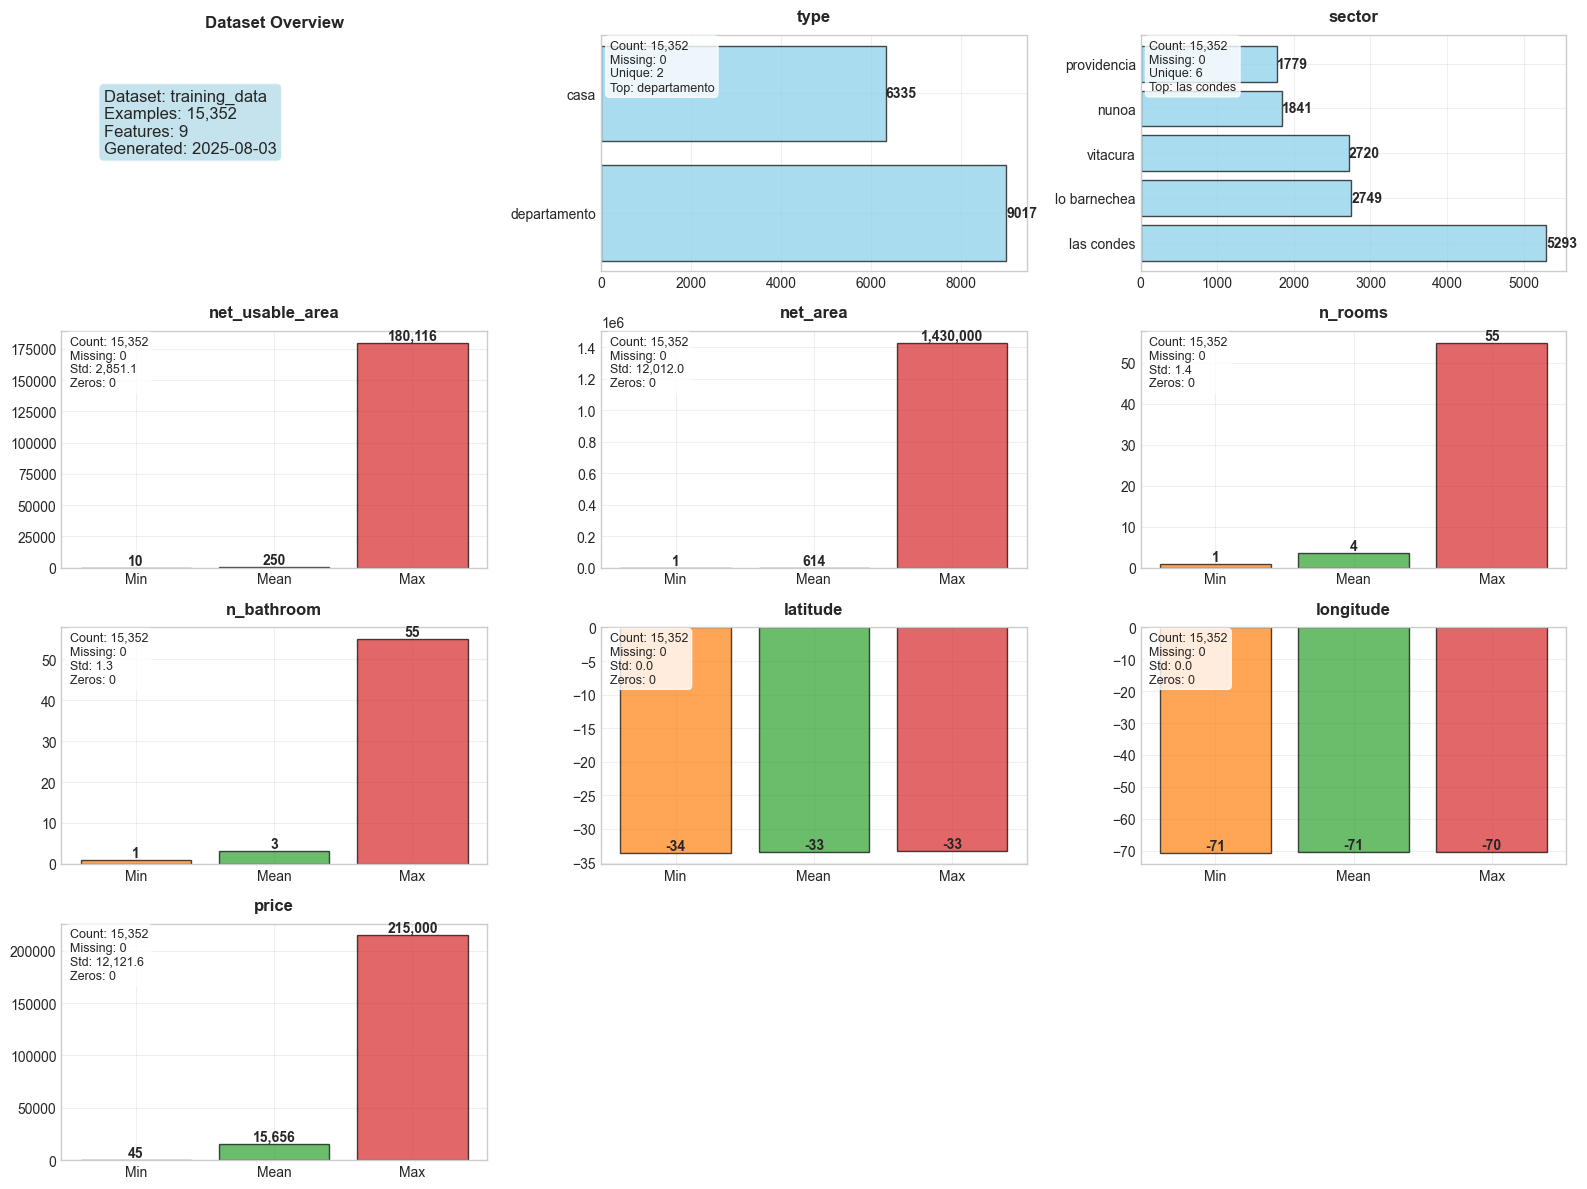

Dataset: training_data
Number of rows: 15,352
Number of columns: 9

Column Summary:
  - type: Categorical, 2 unique values, 0.00% missing
  - sector: Categorical, 6 unique values, 0.00% missing
  - net_usable_area: Numerical, 950 unique values, 0.00% missing
  - net_area: Numerical, 1726 unique values, 0.00% missing
  - n_rooms: Numerical, 20 unique values, 0.00% missing
  - n_bathroom: Numerical, 18 unique values, 0.00% missing
  - latitude: Numerical, 6315 unique values, 0.00% missing
  - longitude: Numerical, 6328 unique values, 0.00% missing
  - price: Numerical, 3233 unique values, 0.00% missing


In [26]:
# Visualize the schema statistics (similar to tfdv.visualize_statistics)
fig = visualize_statistics(train_schema)
plt.show()

# Print additional summary information
print(f"Dataset: {train_schema['dataset_name']}")
print(f"Number of rows: {train_schema['shape']['rows']:,}")
print(f"Number of columns: {train_schema['shape']['columns']}")
print("\nColumn Summary:")
for col, info in train_schema['columns'].items():
    col_type = "Categorical" if 'categorical' in info else "Numerical"
    null_pct = (info['null_count'] / train_schema['shape']['rows']) * 100
    print(f"  - {col}: {col_type}, {info['unique_values']} unique values, {null_pct:.2f}% missing")


## 8. Schema Validation for New Data

### Purpose
Schema validation is a critical quality control mechanism in production ML pipelines. This section demonstrates how we validate new data against our established schema to ensure data integrity and model reliability.

### Validation Process
Our validation framework performs multiple checks:
1. **Structural Validation**: Ensures all required columns are present with correct data types
2. **Range Validation**: Verifies numerical values fall within expected ranges
3. **Categorical Validation**: Confirms categorical values belong to known sets
4. **Distribution Validation**: Checks for significant distribution shifts
5. **Missing Value Validation**: Monitors missing value patterns

### Production Implementation
In a production environment, this validation process:
- Acts as a gatekeeper for new data entering the pipeline
- Triggers alerts when data quality issues are detected
- Provides detailed diagnostics for troubleshooting
- Can be configured with different severity levels for violations
- Maintains an audit trail of validation results


In [27]:
# Set up logging
logging.basicConfig(level=logging.INFO)

# Validate test data against training schema
is_valid, violations = validate_against_schema(
    test_data,
    schema_path,
    log_violations=True
)

print(f"Data is valid: {is_valid}")
if violations:
    print("Violations found:")
    for violation in violations:
        print(f"  - {violation}")


Data is valid: False
Violations found:
  - Column net_usable_area: value 0.0 below minimum 10.0
  - Column net_usable_area: value 250000.0 above maximum 180116.0
  - Column net_area: value 0.0 below minimum 1.0
  - Column n_rooms: value 0.0 below minimum 1.0
  - Column n_bathroom: value 0.0 below minimum 1.0
  - Column latitude: value -33.5383 below minimum -33.52441
  - Column longitude: value -70.64698 below minimum -70.64366
  - Column price: value 14 below minimum 45.0


In [28]:
# Demonstrate schema validation with example data
import logging
from src.data.generate_schema import validate_against_schema

logging.basicConfig(level=logging.INFO, format='%(levelname)s: %(message)s')

# Create example of a typical property record
typical_property = pd.DataFrame({
    'type': ['departamento'],
    'sector': ['las condes'],
    'net_usable_area': [120.0],
    'net_area': [150.0],
    'n_rooms': [3.0],
    'n_bathroom': [2.0],
    'latitude': [-33.4],
    'longitude': [-70.55],
    'price': [15000]
})

# Validate against the schema
print("Validating a typical property record against the schema:")
is_valid, violations = validate_against_schema(typical_property, schema_path)
print(f"Data is valid: {is_valid}")
if violations:
    print("Violations found:")
    for violation in violations:
        print(f"  - {violation}")
else:
    print("No violations found - data conforms to schema")

# Create example of an atypical property with potential data quality issues
atypical_property = pd.DataFrame({
    'type': ['mansion'],  # Unusual property type
    'sector': ['new_development'],  # New sector not in training data
    'net_usable_area': [5000.0],  # Unusually large area
    'net_area': [6000.0],
    'n_rooms': [15.0],  # Many rooms
    'n_bathroom': [10.0],  # Many bathrooms
    'latitude': [-33.4],
    'longitude': [-70.55],
    'price': [1000000]  # Very high price
})

print("\nValidating an atypical property record against the schema:")
is_valid, violations = validate_against_schema(atypical_property, schema_path)
print(f"Data is valid: {is_valid}")
if violations:
    print("Violations found:")
    for violation in violations:
        print(f"  - {violation}")

print("\nThis demonstrates how schema validation can help identify potential data quality issues or outliers in new data.")
print("In a production environment, these violations would trigger alerts or special handling procedures.")


Validating a typical property record against the schema:
Data is valid: True
No violations found - data conforms to schema

Validating an atypical property record against the schema:
Data is valid: False
Violations found:
  - Column type: invalid values {'mansion'}
  - Column sector: invalid values {'new_development'}
  - Column price: value 1000000 above maximum 215000.0

This demonstrates how schema validation can help identify potential data quality issues or outliers in new data.
In a production environment, these violations would trigger alerts or special handling procedures.


## 9. Summary and Conclusions

### Key Insights from the Exploratory Data Analysis

This comprehensive analysis has yielded several valuable insights that will directly inform our real estate valuation model development:

#### 1. Data Quality Considerations
- **Zero Values**: Identified and removed zero values in critical fields that would distort model training
- **Missing Data**: Analysis revealed minimal missing data issues, requiring limited imputation
- **Data Integrity**: Established a robust data cleaning pipeline essential for accurate property valuation

#### 2. Price Distribution Characteristics
- **Skewness**: Property prices exhibit strong right-skewed distribution with significant outliers
- **Transformation**: Log transformation of prices produces a more normal distribution, suggesting a potential preprocessing step
- **Segmentation**: Price variations are substantial across different property types and sectors, indicating the need for segmented modeling approaches

#### 3. Feature Relationship Analysis
- **Area-Price Correlation**: Strong positive correlations exist between area measurements and price (primary value driver)
- **Room Count Impact**: Number of rooms and bathrooms shows clear positive correlation with price, with non-linear effects
- **Property Type Variations**: Different property types have distinct price distributions and value ranges, requiring specialized handling

#### 4. Geographic Insights
- **Spatial Clustering**: Properties cluster in specific geographic regions with distinct characteristics
- **Location Premium**: Price variations follow clear geographic patterns, confirming location as a critical factor
- **Neighborhood Effects**: Evidence of neighborhood-specific pricing patterns that should be incorporated into the model

#### 5. Advanced Outlier Detection
- **Contextual Detection**: The hierarchical grouping approach provides a sophisticated, context-aware view of outliers
- **Segment-Specific Anomalies**: Outliers identified within specific property segments offer more meaningful insights
- **Outlier Classification**:
  - **Luxury Properties**: Some outliers represent genuine luxury or unique properties
  - **Data Errors**: A subset likely represents data entry or collection errors
  - **Market Anomalies**: Others may indicate unusual market conditions or transactions

### Recommendations for Model Development

Based on our analysis, we recommend the following approach for developing the real estate valuation model:

#### 1. Data Preparation Strategy
- **Clean Dataset**: Use the cleaned dataset with zeros removed and outliers identified
- **Transformation Pipeline**: Implement log transformation of price for modeling
- **Validation Framework**: Incorporate the schema validation system for ongoing data quality control

#### 2. Feature Engineering Approach
- **Derived Features**: Create ratio-based and interaction features (price/m², room-to-area ratios)
- **Geographic Features**: Develop location-based features using clustering and neighborhood encoding
- **Categorical Encoding**: Implement sophisticated encoding for property types and sectors

#### 3. Modeling Architecture
- **Segmented Models**: Consider separate models for different property segments or ensemble approaches
- **Outlier Handling**: Implement appropriate treatment of outliers in the modeling pipeline
- **Robust Techniques**: Use algorithms less sensitive to outliers (gradient boosting, robust regression)
- **Evaluation Metrics**: Focus on segment-specific performance metrics rather than overall metrics

#### 4. Production Implementation
- **Pipeline Integration**: Integrate the data processing, validation, and outlier detection into the production pipeline
- **Monitoring System**: Establish ongoing monitoring for data drift and model performance
- **Versioning Strategy**: Maintain versioned schemas and models for traceability and reproducibility
